<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">

<b>Science Seminars: dark energy </b> <br>
Contact author(s): Andrés A. Plazas Malagón, Shenming Fu<br>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP02 <br>
Container Size: medium <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Last verified to run: 2025-03-18 <br>


**Description:** Demonstration of data products relevant for dark energy and cosmology with LSST. 

**Skills:** Use of the catalog data products for dark energy and cosmological analysis. 

**LSST Data Products:** DP0.2 `Object` and `Source` catalogs.

**Packages:** lsst.analysis.tools.atools, lsst.daf.butler, lsst.rsp. 

**Credits:** Developed by Andrés A. Plazas Malagón and Shenming Fu in collaboration with the Rubin Community Science Team for DP0.2. 


This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

Note: this seminar tutorial is based on the tutorial notebooks DP02_12b and DP02_16.

# Part I. Point Spread Function

## 1. Introduction

In the context of astronomical surveys, such as the Vera C. Rubin Observatory's Legacy Survey of Space and Time (LSST), 
a significant objective is to extract cosmological information by scrutinizing subtle deviations in the 
shapes and orientations of galaxies. 
These deviations are caused by gravitational lensing from large-scale structures in the foreground. 
However, the observed shapes of galaxies are not solely influenced by the gravitational lensing effects 
of the universe's large-scale structure (referred to as "cosmic shear"), 
but also by a combined blurring effect known as the point spread function (PSF). 
The PSF arises from various factors such as atmospheric conditions (for ground-based instruments), 
telescope optics, and the image sensor.
PSF analysis is thus an integral part of cosmological studies (and is important in other astronomical fields as well).

**Section 2** introduces and explores the PSF measurements that are available in the `Object` catalogs.
One TAP query is executed: one to retrieve a set of `Objects` detected in the `deepCoadd` images.

**Section 3** illustrates one chromatic dependence of the PSF: the wavelength dependence of the PSF size.

**Section 4** calculates the rho statistics, a series of two-point correlation functions used to diagnose 
the quality of a PSF model for weak lensing analyses. This calculation is done using the `lsst.analysis.tools` framework.


**Additional resources.** 

It is not required to review and understand the following resources before working through this tutorial.

For an overall review on PSF modelling and a look towards the future, see
"Point spread function modelling for astronomical telescopes: a review focused on weak gravitational lensing studies" by
[Liaudat et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230607996L/abstract).
For papers on the impact of chromatic effects on the PSF on weak lensing cosmology see 
"Atmospheric Dispersion Effects in Weak Lensing Measurements" by 
[Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract),
or "Impact of Atmospheric Chromatic Effects on Weak Lensing Measurements" by
[Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract).
For a paper on the impact of differential chromatic refraction (DCR) on supernova cosmlogy, see
"The Dark Energy Survey Supernova Program: Corrections on Photometry Due to Wavelength-dependent Atmospheric Effects" by
[Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract).

For more details on PSF modeling and null tests for galaxy surveys, including `rho` statistics, see
"Dark Energy Survey year 3 results: point spread function modelling" by 
[Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract),
or
"The three-year shear catalog of the Subaru Hyper Suprime-Cam SSP Survey" by
[Li et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract).
And finally, for an approach to a mathematical framework that aids in producing well-defined coadded PSFs for static-sky sources,
see "PSFs of coadded images" by
[Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract).

### 1.1. Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/),
and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing and analysis.


The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.
The `lsst.analysis.tools` package is in-developement by Rubin staff for the 
creation of consistent and repeatable plots and metrics.
Intermediate and advanced users are welcome to use it too; more information is available in the 
[analysis tools documentation](https://pipelines.lsst.io/modules/lsst.analysis.tools/index.html).

Import the LSST Science Pipelines packages for bulter.

> **Warning:** The ``FutureWarning`` that might appear below about ``lsst.pipe.tasks.configurableActions`` being deprecated
> is ok to ignore for now, it does not affect any functionality in this notebook. It will be fixed in the future.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


from lsst.rsp import get_tap_service
from lsst.analysis.tools.atools import RhoStatistics


from scipy.stats import binned_statistic
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

import lsst.daf.butler as dafButler


### 1.2. Define functions and parameters

Instantiate the TAP service for DP0.2 catalog access.

In [2]:
service = get_tap_service("tap")

Set a standard color style.

In [3]:
plt.style.use('tableau-colorblind10')

**Function**: `powerLaw`

Defines a power-law function.

In [4]:
def powerLaw(lam, a, b):
    """Function to return a power-law.

    Parameters
    ----------
    lam : `array`
       array of values
    a : `float`
       constant factor
    b : `float`
       power

    Returns
    -------
    result : `float`
        a*lam**(-b)
    """

    result = a*lam**(-b)
    return result

## 2. The measured PSF properties in the catalogs

Recall that the `Objects`  catalogs contains measurements for astrophysical objects 
detected in the `deepCoadd`  images, respectively.

These measurements include a variety of parameters that characterize the PSF as measured for
that `Object` .
While these parameters are calculated for all detections, they
are only relevant for point-sources (stars) and not extended sources (galaxies).

### 2.1. PSF properties for `Objects`

To explore what PSF-related measurements exist, one option is to page search for the term "psf" in the 
[DP0.2 Catalogs Schema Browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html) for the `Object` table.

**Option:** To retrieve the column names and descriptions for the `Object` table and search for the term "psf",
uncomment the lines in the following cell and execute the cell.
The result is quite a long list, so this cell is commented-out by default.

In [5]:
# results = service.search("SELECT column_name, description "
#                          "from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp02_dc2_catalogs.Object'"
#                          ).to_table().to_pandas()
# for cname, descr in zip(results['column_name'], results['description']):
#     if (cname.find('psf') > -1) | (cname.find('PSF') > -1):
#         print(cname + ' --- ' + descr)
# del results

The `Object` catalog contains measurements for sources detected in the `deepCoadd` images for *all* six filters, *ugrizy*.
Thus, for all the PSF-related measurements in the `Object` catalog, there is one per band.

Some of the most useful PSF-related parameters in the `Object` catalog include the following.

`{band}_psfFlux` and `{band}_psfFluxErr`:
The flux (and its error) derived from linear least-squares forced-fit of PSF model.

`{band}_psfFlux_flag`: A general failure flag for the linear least-squares forced-fit of PSF model (`True` or `1` if failed).

`{band}_ixxPSF`, `{band}_ixyPSF`, and `{band}_iyyPSF`: Second-moments of the shape of the fit PSF model ($I_{xx}$, $I_{yy}$, and $I_{xy}$).

`{band}_calib_psf_used`: A flag that is `True` (or `1`) if the `Object` is a star that was used to establish the PSF model
for the image (i.e., bright isolated stars with well-measured PSF properties).

`{band}_pixelFlags_inexact_psfCenter`: A flag that is `True` (or `1`) if the `Object` is close to image pixels which do not
have an exact PSF, typically because they are near an image edge. 
Objects near these edges can have a discontinuous PSF.

#### 2.1.1. Retrieve a sample of `Objects`

Use the same central coordinates as were used to retrieve the images in the introductory PSF tutorial notebook
(DP02_12a_PSF_Data_Products.ipynb).

Use the same default filter, *i*.

In [6]:
use_center_coords = "53.0, -34.1"
band = 'i'

The following query retrieves the PSF-related columns mentioned above, plus a few more columns
which will be used later in this notebook, when calculating rho statistics with the analysis tools pacakge.

The `WHERE` statements for this query require object to:
 - be within a 2 degree radius around the center coordinates;
 - have a `detect_isPrimary` flag that is `True` (`1`), which is always recommended as a way to avoid duplicates and unblended objects;
 - have a flux $> 360$ nJy (i.e., be bright);
 - have an extendedness parameter $= 0$ (stars only, no extended objects);
 - have a `{band}_calib_psf_used` flag that is `True` (`1`), such that only stars with well-measured PSF properties are returned;
 - and have a `{band}_pixelFlags_inexact_psfCenter` flag that is `False` (`0`) to avoid stars near the image edge.
 
The choice to requre that `i_pixelFlags_inexact_psfCenter = 0` is influenced by the fact that the `EDGE` 
flag in a `calexp` corresponds to the `SENSOR_EDGE` flag in the `coadd`. 
Objects near these edges have a discontinuous PSF. 
Additionally, the `inexact_psfCenter` results from an `OR` operation that includes `SENSOR_EDGE`. 
The other properties retrieved through the query will play a role in calculating the `rho` statistics, 
which will be the subject of Section 5 in this notebook.

In [7]:
objects = service.search("SELECT coord_ra, coord_dec, "
                         f"{band}_psfFlux, "
                         f"{band}_psfFluxErr, "
                         f"{band}_psfFlux_flag, "
                         f"{band}_pixelFlags_saturatedCenter, "
                         f"{band}_extendedness, "
                         f"{band}_extendedness_flag, "
                         f"{band}_ixy, {band}_ixyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, "
                         "xy_flag, sky_object, "
                         "detect_isPatchInner, "
                         "detect_isDeblendedSource "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         f"AND {band}_calibFlux > 360 "
                         f"AND {band}_extendedness = 0.0 "
                         f"AND {band}_calib_psf_used = 1 "
                         f"AND {band}_pixelFlags_inexact_psfCenter = 0 ").to_table().to_pandas()

**Option:** View the table. This query returns 8426 rows.

In [8]:
# objects

Calculate the trace radius (PSF size, $r_t$) for the *u*, *g*, *r*, and *i*-band 
from the second moments of the PSF shape as $r_t = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$.

In [9]:
for band in ['u', 'g', 'r', 'i']:
    objects['size_'+band+'_PSF'] = np.sqrt((objects[band + '_ixxPSF']
                                            + objects[band + '_iyyPSF']) / 2)

The PSF sizes in different filters will be used below to explore the wavelength dependence of seeing.

In [10]:
obj_ra = objects['coord_ra']
obj_dec = objects['coord_dec']

## 3. The wavelength dependence of seeing  

To correct for the effects of the Point Spread Function (PSF) and to deduce the weak lensing signal (referred to as "shear") from galaxy shapes, the PSF is typically modeled using stars, often bright ones. Subsequently, the PSF of galaxy images is deconvolved by utilizing the estimated PSF convolution kernel. Implicit in this methodology is the assumption that the convolution kernel for galaxies remains the same as that for stars. However, this assumption becomes invalid if the PSF varies with wavelength due to the distinctive Spectral Energy Distributions (SEDs) of stars and galaxies, resulting in disparate PSFs.

In this section, use the point source sample derived from the `Object` catalog, which was obtained in the preceding sections. Aftwerward, compute one of the wavelength-dependent components contributing to the PSF owing to atmospheric effects: the wavelength dependence on seeing. As per the standard theory of atmospheric turbulence, the linear dimension `θ` of the atmospheric convolution kernel (i.e., seeing) is inversely proportional to the wavelength, expressed as $\theta \propto \lambda^{-\frac{1}{5}}$.

Additional wavelength-dependent contributions to the PSF encompass Differential Chromatic Refraction (DCR), telescope diffraction, variations in the absorption length of camera CCDs, and optical chromatic aberrations. In general, each of these factors exhibits distinct functional wavelength dependencies and may exert dominance in different spectral bands. Nevertheless, the wavelength-dependent seeing that we explore in this section tends to be the primary contributor to the PSF. These chromatic PSF effects introduce biases in observables such as photometry, astrometry, measurements of galaxy shape and size, and higher-order moments of the PSF. Addressing these effects is imperative for precise cosmological analysis employing weak gravitational lensing. For more detailed information, refer to the works of [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract), [Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract), [Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract), [Tianqing et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.520.2328Z/abstract), and [Meyers and Burchat 2015b](https://ui.adsabs.harvard.edu/abs/2015JInst..10C6004M/abstract).

To replicate this wavelength relationship using the date retreived above, compute first the central wavelengths of the broadband filters employed by LSST, alongside determining the mean size and its standard deviation for each respective band. The boundaries of the filters are available in Table 2.1 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).

In [11]:
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(objects['size_u_PSF']),
             np.mean(objects['size_g_PSF']),
             np.mean(objects['size_r_PSF']),
             np.mean(objects['size_i_PSF'])]

std_size = [np.std(objects['size_u_PSF']),
            np.std(objects['size_g_PSF']),
            np.std(objects['size_r_PSF']),
            np.std(objects['size_i_PSF'])]

Fit now a power-law to the mean PSF size in relation to wavelength by employing [`scipy.optimize.curvefit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). 

This function takes the functional form to be fitted as its first argument, followed by two arrays containing the data. The output is a tuple consisting of the optimized parameters that minimize the squared residuals of the function with respect to the measured data, labeled as `popt`. Additionally, it provides the estimated 2D covariance matrix of the fitted parameters, denoted as `pcov`, wherein the diagonal elements offer an estimation of their respective one-standard-deviation errors (for more comprehensive information, refer to [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

In [12]:
popt, pcov = curve_fit(powerLaw, wavelength, mean_size)
perr = np.sqrt(np.diag(pcov))

Use the fitted parameters to define fitted values, and print the parameters of the fit.

In [13]:
lamb_grid = np.arange(300, 800, 1)
fit_size = powerLaw(lamb_grid, *popt)
amplitude, exponent = popt
amplitude_error, exponent_error = perr
print(f"Amplitude: {amplitude:.3} +/- {amplitude_error:.3}")
print(f"Exponent: {exponent:.3} +/- {exponent_error:.3}")

Amplitude: 5.42 +/- 0.342
Exponent: 0.169 +/- 0.0101


The expected chromatic dependence of the PSF size should follow a power law of approximately $\lambda^{-1/5} \approx \lambda^{-0.2}$ based on Kolmogorov turbulence. However, the fitted observed exponent is closer to $-0.17$, which is lower than expected. This discrepancy likely arises from two competing effects:

1. **Finite Outer Scale of Turbulence:** Kolmogorov turbulence assumes an infinite outer scale, but in real-world atmospheric turbulence and simulations like DP0.2 (based on the [LSST DESC DC2 simulations](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L/abstract)), the outer scale is finite. In this case, the magnitude of the exponent deviates from $-0.2$ and can even exceed it. This suggests that the magnitude of the exponent should be slightly larger than $-0.2$, not smaller (see Figure 6 of [Zhang T. 2018](https://zenodo.org/records/14947939)).

2. **Chromatic Sensor Effects:** The dominant reason the fitted exponent is less than $-0.2$ is likely related to be sensor physics effects. Specifically, redder photons penetrate deeper into the silicon in the LSST CCDs, spreading charge over a larger transverse area due to the steep incoming $f/1.2$ beam. Additionally, the simulation treated the beam inside the silicon as $f/1.2$, whereas in reality, it should be closer to $f/4$ or $f/5$ due to refraction at the silicon surface ([Meyers et al. 2015](https://ui.adsabs.harvard.edu/abs/2015JInst..10C6004M/abstract)). These effects effectively increase the PSF size for redder wavelengths, counteracting the expected $\lambda^{-0.2}$ scaling and reducing the measured exponent.

In summary, while the finite atmospheric outer scale should have pushed the exponent slightly above $-0.2$, chromatic sensor effects had the opposite sign, resulting in an overall best-fit exponent of approximately $-0.17$.

Plot the mean PSF size per band as a function of wavelength.

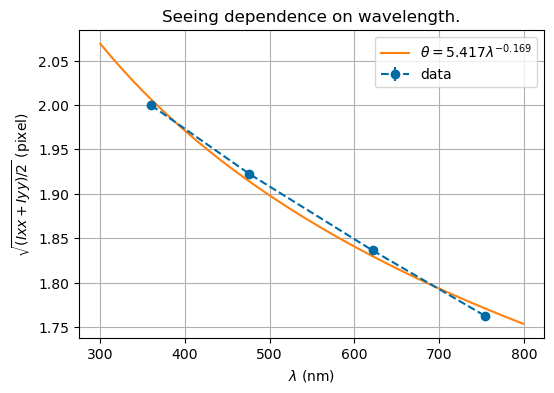

In [14]:
plt.figure(figsize=(6, 4))
plt.errorbar(wavelength, mean_size, std_size/np.sqrt(len(objects)),
             fmt='o--', label='data')
plt.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
plt.title("Seeing dependence on wavelength.")
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

> **Figure 3**: *The plot above depicts the mean PSF size (expressed as the trace radius in pixels) in relation to the central wavelength for the previously specified LSST filters. Additionally, a power-law fit is presented on the same plot, with the associated amplitude and fitting parameters indicated within the legend.*

Superimpose the size hisograms per band and the plot in Figure 3.

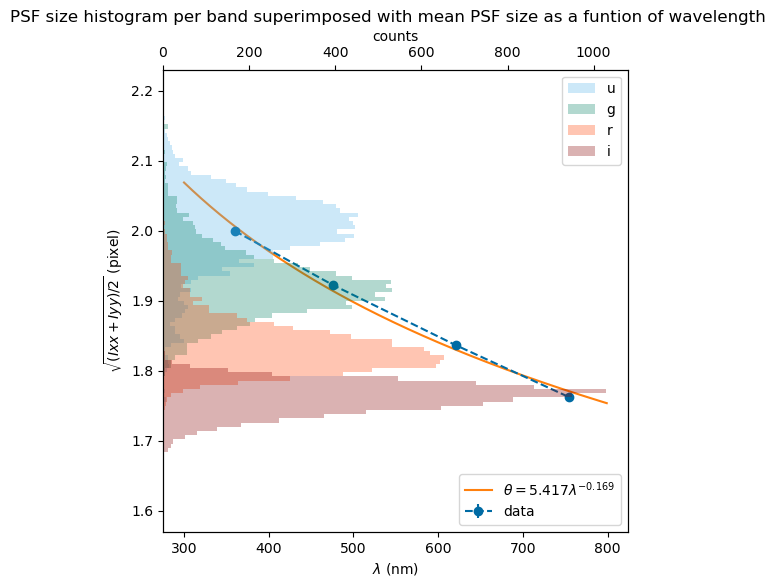

In [15]:
fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength, mean_size, std_size/np.sqrt(len(objects)),
             fmt='o--', label='data')
ax1.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()

plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}

ax2.set_xlabel('counts')
plt.hist(objects['size_u_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['u'], alpha=0.3, label='u',
         orientation="horizontal")
plt.hist(objects['size_g_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['g'], alpha=0.3, label='g',
         orientation="horizontal")
plt.hist(objects['size_r_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['r'], alpha=0.3, label='r',
         orientation="horizontal")
plt.hist(objects['size_i_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['i'], alpha=0.3, label='i',
         orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.suptitle("PSF size histogram per band superimposed with "
             "mean PSF size as a funtion of wavelength")
plt.show()

> **Figure 4**: *The figure above superimposes the size distributions per band onto the previously generated plot in Figure 3. The figure includes histograms of the size distributions corresponding to each band (`u`, `g`, `r`, and `i`), rotated 270 degrees to align their bases with the left vertical axis. The upper horizontal axis displays the histogram counts, spanning from 0 to approximately 1200 counts. Notably, this plot serves a dual role, as it incorporates both the data for the PSF size as a function of wavelength and the power-law fit from the preceding plot.*

## 4. Rho statistics with the `analysis.tools` package

Utilize [`lsst.analysis.tools`](https://github.com/lsst/analysis_tools) to compute the `rho` statistics, which are a collection of two-point correlation functions used to assess the spatial relationships between errors in PSF models. The presence of non-zero values in these statistics signifies the existence of systematic errors in the weak lensing shear correlation function. To understand their definitions, refer to [the analysis tools documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). 

`lsst.analysis.tools` is a package designed to generate quality assurance (QA) plots and metrics from the outputs of the LSST Science Pipelines. It employs `treecorr` to compute the `rho` statistics. For an introductory demonstration of `analysis_tools`, you can refer to [this Jupyter Notebook created for a session during Rubin's 2022 Project and Community Workshop](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb).

Create the `RhoStatistics` analysis structure using the `AnalysisTool`. As outlined in the [2022 Rubin PCW `analysis_tools` demo notebook](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb), the `AnalysisTool` is one of the three analysis structures provided by `analysis_tools`. It encompasses several `AnalysisAction` components, which collectively conduct specific types of analyses.

In [16]:
atool = RhoStatistics()

There are three types of `AnalysisAction`s or stages: 

- `prep` (for initial filtering of data), 
- `process` (for modyfing the data), and 
- `produce` (for generating final plots of metrics). 

Abjust a few configuration parameters from the `prep` and `process` stages.

Select stars with with signal-to-noise ratio (SNR) > 20.

In [17]:
atool.prep.selectors.snSelector.threshold = 20.0

As in a previous section, we can adjust the `treecorr` parameters before calculations, but this time it will be done via `lsst.analysis.tools`.

In [18]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

Call `atool.finalize()` after the `atool.prep` and `atool.process` stages are configured.

In [19]:
atool.finalize()

The TAP query in section 2.1 included fields that not used in that section, but that will be used in this section. 

In order to know which entries will be needed by `analysys_tools` to calculate the `rho` statistics, look at the input schema of the analysis tool `RhoStatistics`.

In [20]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_dec', 'coord_ra', '{band}_ixx', '{band}_ixxPSF', '{band}_ixy', '{band}_ixyPSF', '{band}_iyy', '{band}_iyyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'sky_object', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


Compute the `rho` statistics in the particular band that we have chosen previously (`i`).

Start with the `prep` stage in the following cell.

In [21]:
prepResults = atool.prep(objects, band=f"{band}")

Execute the `process` stage, utilizing the outcomes obtained from the `prep` stage. Ignore the `INFO` lines.

In [22]:
processResults = atool.process(prepResults, band=f"{band}")

Access the results from `treecorr` for each `rho` statistic in order to examine the values or perform any other operation on them.

In [23]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.11941126  0.17058738  0.23258897  0.32345946  0.44517692  0.62248141
  0.86913481  1.20581532  1.67380059  2.32922795  3.23268855  4.48739349
  6.23612466  8.66423628 12.04021829 16.71729478 23.22682611 32.24748144
 44.7807177  62.14420363 86.20329434] 

Correlation function:
 [ 5.57916408e-07  1.09044514e-07  2.62357638e-07  5.91508817e-07
  4.36905550e-07  9.80089124e-08  1.02121282e-07 -7.50198788e-08
  1.44547786e-07  7.55552294e-08  5.26494872e-08  2.47729947e-08
  3.46230746e-08  5.79992776e-08  4.55251123e-08  4.17772383e-08
  4.12712390e-08  4.00861331e-08  3.81000298e-08  3.70912282e-08
  3.67326870e-08] 

Error in the correlation function:
 [2.37425808e-13 1.34541291e-13 6.95903231e-14 3.93779389e-14
 2.07518701e-14 1.15817467e-14 5.85386329e-15 3.06007486e-15
 1.62751562e-15 8.49734471e-16 4.44299492e-16 2.36875421e-16
 1.24844997e-16 6.64620244e-17 3.54709442e-17 1.91998874e-17
 1.06334336e-17 6.04792312e-18 3.51732896e-18 2.11320515e-18
 1.339

Plot the `rho` statistics using `analysis_tools` 

By default, the rho statistics are plotted on a symmetric log scale.
The threshold where the switch happens from linear to log scale can be set as follows.

In [24]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

At the moment, `atool.produce` does nto provide a direct handle to the plotting keyword arguments. 

Overwrite the global plotting parameters in order to make figures with a size suitable for a Jupyter notebook.

In [25]:
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['lines.markersize'] = 2
plt.rcParams['xtick.labelsize']=5
plt.rcParams['ytick.labelsize']=5
plt.rcParams['font.size']=5

Use `analysis_tools` to produce the `rho` statistics plots.

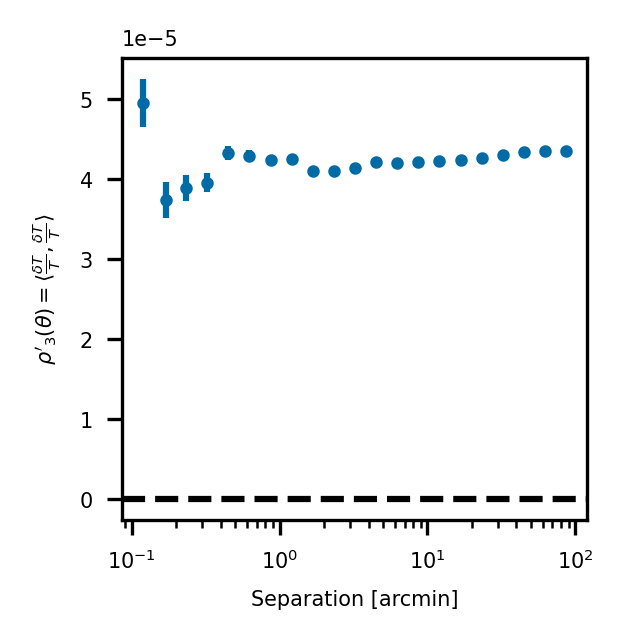

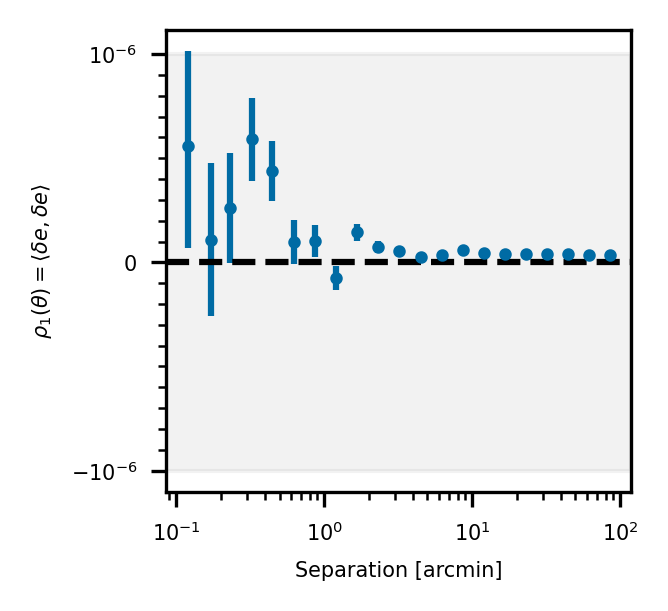

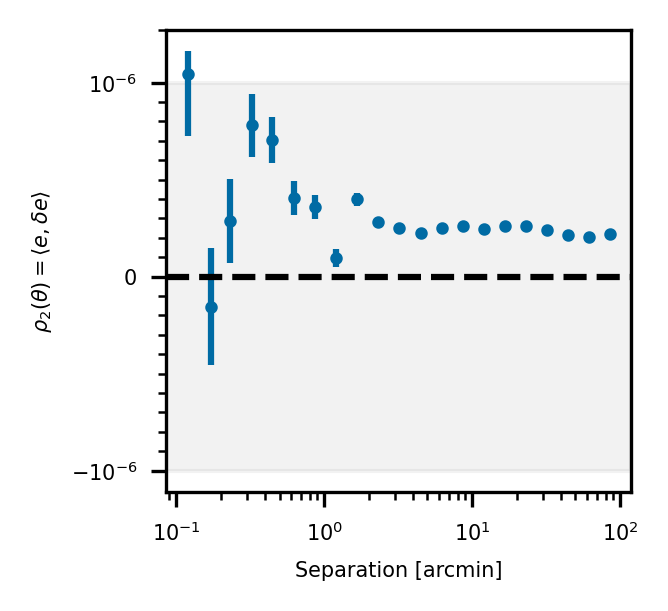

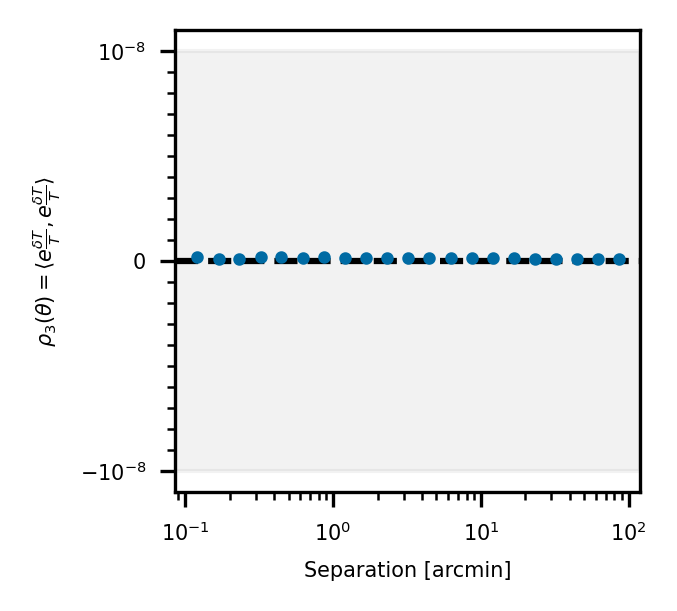

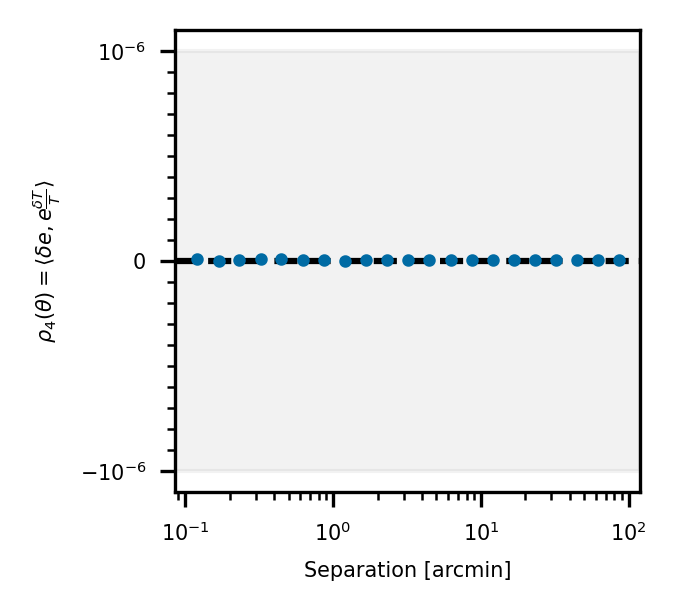

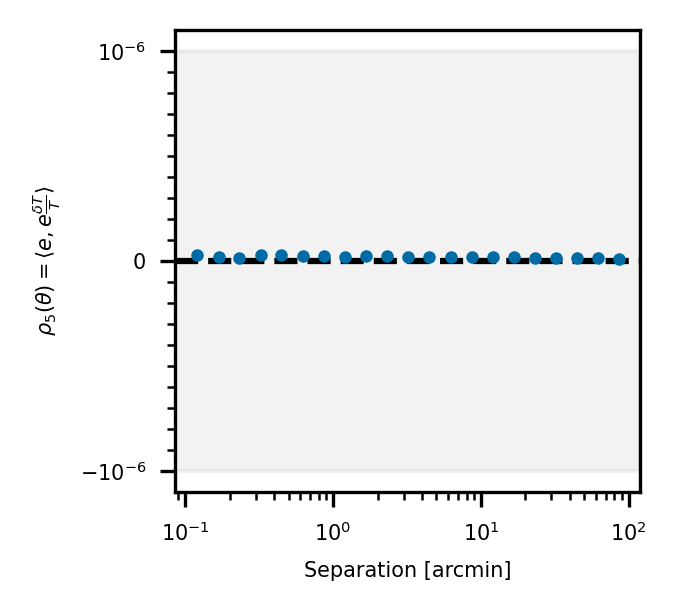

In [26]:
produceResults = atool.produce(processResults, band=f"{band}", skymap=None)

> **Figure 5** *This figure displays six plots of the `rho` statistics using `analysis_tools`. 
For other possible configuration options, you can refer to 
[the documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.plot.XYPlot.html#lsst.analysis.tools.actions.plot.XYPlot). 
The vertical axis of each plot displays the specific `rho` statistic, and the horizontal axis represents the separation in arcminutes, ranging from approximately 0.1 to 100 arcminutes on a logarithmic scale.*

As explained in [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), `rho1` (ρ1), `rho3` (ρ3), and `rho4` (ρ4) represent direct systematic errors in `xi+` (ξ+) with leading coefficients of order unity. `rho2` (ρ2) and `rho5` (ρ5) describe the extent of "PSF leakage" that occurs during the shear measurement process.

The DC2 area is relatively small and does not exhibit significant PSF variations. The `rho` statistics obtained in the previous examples (for the `i` band, considering that `rho` statistics can vary with different bands) are relatively small and well-behaved. For comparison, you can refer to Figure 26 of the [HSC Y3 shape catalog](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract) and Figure 12 of the [DES Y3 shape catalog analyses](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), which display `rho` statistics obtained from on-sky data from their respective galaxy surveys (HSC Survey and DES). These figures also include the requirements that each `rho` statistic should satisfy (e.g., Eq. 37 of [Li et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)) to ensure that there are no significant PSF modeling systematic errors that would impact the scientific goals related to cosmic shear.


# Part II. Cluster lensing

## 1. Introduction

Galaxy clusters are the largest gravitionally bound objects in the Universe. According to the General Relatively, massive objects warp the spacetime, and light follows the curvature of spacetime. Thus, massive objects act like lenses that bend the path of the light emitted from distance sources. This effect is called "gravitional lensing". 

The large mass of a galaxy cluster coherently distorts the images of backgroud galaxies, and this distortion occurs over a large sky area around the cluster. The lensing effect on the shape of a single background galaxy far from the cluster center is small, but the lensing signal can be detected by averaging the shape of many background galaxies. This is because the original shapes of the galaxies are randomly oriented. This effect is called weak gravitational lensing (WL), which shows up in the statistics of a large sample of galaxy shapes. More detailed introduction to cluster WL can be found in review papers (e.g., [Bartelmann & Schneider 2001](https://ui.adsabs.harvard.edu/abs/2001PhR...340..291B/abstract); [Umetsu 2020](https://ui.adsabs.harvard.edu/abs/2020A%26ARv..28....7U/abstract)). 

Note that WL also happens between galaxies and when the light passes through the large-scale structure of the Universe (cosmic shear). Compared to galaxy-galaxy lensing and cosmic shear, the cluster WL signal is generally about 1 magnitude higher (at the level of 10 times). 

This notebook gives an example of detecting lensing signal of clusters using DP0 data.

## 2. Get the coadd object catalog around a cluster
There is a known cluster at (55.749deg, -32.273deg) for Right Ascension (RA), DEClination (DEC). Make a cone search for primary objects with radius 15 arcmin using Table Access Protocol (TAP). 
More details about the TAP service can be found in the tutorial Notebook for TAP (DP02_02a Introduction to TAP). 

Select galaxies by extendedness, which is the difference between the Point Spread Function (PSF) photometry and the Composite-Model (CModel) photometry ([Abazajian et al. 2004](https://ui.adsabs.harvard.edu/abs/2004AJ....128..502A/abstract), [Bosch et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract)). CModel measures extended objects and is used for galaxy photometry generally. 

Use the `g` and `r` band color information to remove foreground galaxies, applying relevant flag cuts. Additionally, use the `r` band for shape analysis. Using the `r` band shapes is common in weak lensing studies. The main reason is the balance between seeing and sky brightness for shape measurement ([Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...84F)). Another reason is that Differential Chromatic Refraction (DCR) is weaker in redder bands, which reduces the PSF elongation along the zenith and makes the galaxy's pre-PSF shape easier to measure ([Plazas et al. 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract)). 
Also, apply quality cuts to the shape measurements of galaxies for WL analysis ([Mandelbaumet al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). 

For simplicity, skip the use of photometric redshift (photo-z) in this notebook. While the photo-z information can help select background galaxies by redshift, background galaxies can also be selected directly by color. 


In [27]:
service = get_tap_service("tap")
assert service is not None

In [28]:
center_ra = 55.749
center_dec = -32.273
radius = 15/60.

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

query = "SELECT r_ra, r_decl, "\
        "r_cModelFlux, r_cModelFluxErr, g_cModelFlux, g_cModelFluxErr, "\
        "r_hsmShapeRegauss_e1, r_hsmShapeRegauss_e2, x, y "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 "\
        "AND r_extendedness = 1 "\
        "AND r_extendedness_flag = 0 "\
        "AND r_cModel_flag = 0 "\
        "AND g_cModel_flag = 0 "\
        "AND r_psfFlux_flag = 0 "\
        "AND r_centroid_flag = 0 "\
        "AND r_hsmShapeRegauss_sigma < 0.4 "\
        "AND r_blendedness < 0.42 "


print(query)

SELECT r_ra, r_decl, r_cModelFlux, r_cModelFluxErr, g_cModelFlux, g_cModelFluxErr, r_hsmShapeRegauss_e1, r_hsmShapeRegauss_e2, x, y FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 55.749, -32.273, 0.25)) = 1 AND detect_isPrimary = 1 AND r_extendedness = 1 AND r_extendedness_flag = 0 AND r_cModel_flag = 0 AND g_cModel_flag = 0 AND r_psfFlux_flag = 0 AND r_centroid_flag = 0 AND r_hsmShapeRegauss_sigma < 0.4 AND r_blendedness < 0.42 


Run the job.

In [29]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


Finally, save the results into an astropy table.

In [30]:
data = job.fetch_result().to_table()
job.delete()

Delete the variable.

In [31]:
del query

Apply some further cuts on the `g` and `r` band photometry to ensure the quality. First require the flux error to be positive to remove unphysical measurements.

In [32]:
data = data[data['r_cModelFluxErr'] > 0]
data = data[data['g_cModelFluxErr'] > 0]

Make selection based on signal-to-noise ratio (SNR). Make a typical 5-sigma cut on SNR to select well-detected objects.

In [33]:
r_SNR = data['r_cModelFlux'] / data['r_cModelFluxErr']
g_SNR = data['g_cModelFlux'] / data['g_cModelFluxErr']

sel = r_SNR > 5.
sel &= g_SNR > 5.

WL distorts galaxy shapes, which are described by ellipticity. The ellipticity is constructed from the second moments of the object's 2D flux distribution, corrected for PSF effects. 
The HSM shape measurement is available in the catalog. The details of HSM are described in the work of [Hirata and Seljak (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract) and [Mandelbaum et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract). 

Require the measured ellipticity to be within 2. This removes galaxies with very large measured ellipticities that are unphysical, but allows galaxies with measured ellipticities slightly larger than 1 caused by noise ([Mandelbaum et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). 

For HSM shapes, the mean ellipticity divided by 2 approximates the lensing shear. Between the measured shear and the true shear there is a small bias, which is caused by galaxy shape dispersion, measurement noise, pixelization, and other effects. Usually, a shear calibration corrects for this bias. However, accurately determining shear calibration parameters requires further image simulation, which is beyond the scope of this notebook. Thus, for demonstration, skip shear calibration but focus on studying the mean galaxy shape in this notebook.

In [34]:
e1 = data['r_hsmShapeRegauss_e1']
e2 = data['r_hsmShapeRegauss_e2']
sel &= (e1**2 + e2**2)**0.5 < 2.
print("Fraction of large ellipticity: ", np.sum(~sel)/len(data))

Fraction of large ellipticity:  0.04576001108493834


Make the selection. 

In [35]:
data_s = data[sel]

## 3. Select galaxies by color

Create a `g-r` vs `r` color-magnitude diagram (CMD) of galaxies. Clusters generally show a red sequence (RS) in the CMD due to evolution -- those red galaxies are the oldest and reddest in the cluster ([Kodama and Arimoto 1997](https://ui.adsabs.harvard.edu/abs/1997A%26A...320...41K/abstract); [Gladders and Yee 2000](https://ui.adsabs.harvard.edu/abs/2000AJ....120.2148G/abstract)). Galaxies that are redder than the RS are background galaxies. Thus, use colors to select a sample of background galaxies, and a sample of bright cluster member galaxies -- they show different colors in the CMD. Here is also an example tutorial of using the Rubin Science Platform (RSP) Portal to study the RS ([Exploring Extended Object Populations with Histograms](https://dp0-2.lsst.io/tutorials-examples/portal-4.html)).

First, convert flux into magnitude and compute the magnitude uncertainty, based on the tutorial notebook DP02_01 (Introduction to Jupyter Notebooks for Data Preview 0.2). Note, the derivation of the magnitude uncertainty comes from the difference of the magnitude equation. Because $m = -2.5 * log(F) + m0$, where $m0$ is the magnitude zero, $m$ is the magnitude, and $F$ is the flux. Then $dm = -2.5/ln(10) * dF / F$, and the SNR is $F / dF$. 

In [36]:
r_cModel = -2.5*np.log10(data_s['r_cModelFlux']) + 31.4
g_cModel = -2.5*np.log10(data_s['g_cModelFlux']) + 31.4

fac = 2.5 / np.log(10)
r_cModel_err = fac / r_SNR[sel]

Make the CMD. 

There is a concentration of galaxies at $g-r\approx1.1$, when the galaxies have different brightness (`r` band magnitude). That concentration represents the RS. Select galaxies redder than that to get background galaxies, and allow some gap from the the RS because of magnitude measurement uncertainties. 

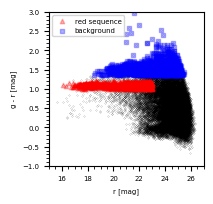

In [37]:
plt.figure()
plt.scatter(r_cModel,
            g_cModel - r_cModel,
            s=0.03, c='k', marker='.')

sel_rs = g_cModel - r_cModel > 1.0
sel_rs &= g_cModel - r_cModel < 1.2
sel_rs &= r_cModel < 23.

plt.scatter(r_cModel[sel_rs],
            (g_cModel - r_cModel)[sel_rs],
            s=10, c='r', alpha=0.3,
            label='red sequence', marker='^')

sel_bg = g_cModel - r_cModel > 1.35

plt.scatter(r_cModel[sel_bg],
            (g_cModel - r_cModel)[sel_bg],
            s=5, c='b', alpha=0.3,
            label='background', marker='s')

_ = plt.legend()

plt.xlim(15, 27)
plt.ylim(-1, 3.)
plt.xlabel('r [mag]')
plt.ylabel('g - r [mag]')
plt.minorticks_on()

> Figure 1: Color-magnitude of galaxies with markers showing the selected background galaxies and the bright red sequence galaxies. 

Check the relation between the `r` band magnitude and uncertainty, and compare that with SNR. In the figure, the uncertainty grows as the magnitude increases (i.e., the objects are fainter), which is expected.

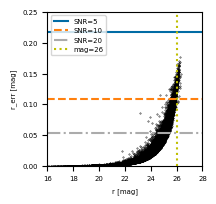

In [38]:
plt.figure()

plt.scatter(r_cModel,
            r_cModel_err,
            s=0.1, c='k')

ls_list = ['-', '--', '-.']
for i, SNR in enumerate([5, 10, 20]):
    plt.axhline(fac / SNR, c='C%d'%i, label='SNR=%d'%SNR, ls=ls_list[i])

plt.xlim(16, 28)
plt.ylim(0, 0.25)

plt.axvline(26, c='y', ls=':', label='mag=26')

plt.xlabel('r [mag]')
plt.ylabel('r_err [mag]')

_ = plt.legend()

> Figure 2: r-band magnitude and uncertainty of galaxies.

Now, check the distribution of galaxies on the sky. Clearly, the RS galaxies have a concentration near the cluster center, but the background ones are uniformally distributed. 

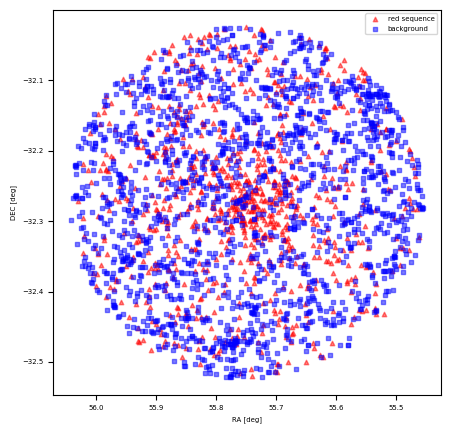

In [39]:
ra = data_s['r_ra']
dec = data_s['r_decl']

plt.figure(figsize=(5, 5))
plt.scatter(ra[sel_rs], dec[sel_rs], s=10, c='r',
            label="red sequence", marker='^', alpha=0.5)
plt.scatter(ra[sel_bg], dec[sel_bg], s=5, c='b',
            label="background", marker='s', alpha=0.5)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.gca().invert_xaxis()
_ = plt.legend()

> Figure 3: Sky distribution of the selected background and red sequence galaxies.

## 4. Lensing analysis

Compute the tangential and cross ellipticities of background galaxies with respect to the cluster center. 

In the following formulae, $e_\textrm{T}$ is the tangential ellipticity, $e_\textrm{X}$ is the cross ellipticity, $\varphi$ is the position angle towards the cluster center (top North and left East), $e_1$ and $e_2$ are the original ellipticity components. Note, in the formulae the position angle starts from the negative RA direction (West) and increases counterclockwise, but in Astropy the position angle starts from North. Thus, add $\pi/2$ to the position angle computed by Astropy. 

$e_\textrm{T}= - e_1 \cos(2 \varphi)- e_2 \sin(2 \varphi)$

$e_\textrm{X}= e_1 \sin(2 \varphi) - e_2 \cos(2 \varphi)$

Here, the tangential direction is perpendicular to the line connecting the galaxy and the cluster center, while the cross direction is 45 degrees counterclockwise from the tangential direction.  

Also, compute the radial distance in arcminutes. 

In [40]:
e1 = data_s['r_hsmShapeRegauss_e1']
e2 = data_s['r_hsmShapeRegauss_e2']

coord0 = SkyCoord(center_ra, center_dec, frame='icrs', unit='deg')
coord1 = SkyCoord(ra, dec, frame='icrs', unit='deg')

position_angle = coord0.position_angle(coord1).rad + np.pi/2.

e_t = - e1 * np.cos(2.*position_angle) - e2 * np.sin(2.*position_angle)
e_x = + e1 * np.sin(2.*position_angle) - e2 * np.cos(2.*position_angle)

r = coord0.separation(coord1).arcmin

Examine the distributions of the tangential and cross ellipticities. They both show Gaussian-like distributions, but the tangential ellipticity distribution has a mean slightly above zero, while the cross ellipticity distribution has a mean close to zero ([Kaiser 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...439L...1K/abstract); [Umetsu 2020](https://ui.adsabs.harvard.edu/abs/2020A%26ARv..28....7U/abstract)).

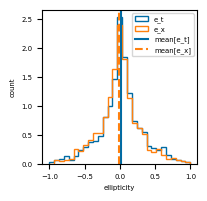

In [41]:
bins = np.linspace(-1, 1, 30)
mid = 0.5 * (bins[1:] + bins[:-1])

plt.figure()

n_e_t, _, im = plt.hist(e_t[sel_bg], bins=bins, histtype='step',
                        density=True, label='e_t')
n_e_x, _, im = plt.hist(e_x[sel_bg], bins=bins, histtype='step',
                        density=True, ls='--', label='e_x')

plt.axvline(np.mean(e_t[sel_bg]), c='C0', label='mean[e_t]')
plt.axvline(np.mean(e_x[sel_bg]), c='C1', ls='--', label='mean[e_x]')

plt.xlabel('ellipticity')
plt.ylabel('count')

_ = plt.legend()

> Figure 5: Distributions of the tangential ellipticities and the cross ellipticities of the selected background galaxies.

The difference between two distributions shows a dipole feature as expected, because this is the difference between two Gaussian-like functions that only have a small offset of the peak. See also an example in the work of [Dell'Antonio et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...903...64D/abstract).

Text(0, 0.5, 'count difference')

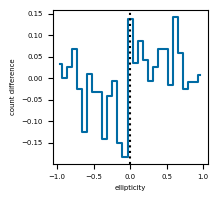

In [42]:
plt.figure()
plt.step(mid, n_e_t - n_e_x, where='mid')
plt.axvline(0, c='k', ls=':')
plt.xlabel('ellipticity')
plt.ylabel('count difference')

> Figure 6: Difference between the distributions of the tangential ellipticities and the cross ellipticities.

Bin the data by radial distance to get the mean tangential and cross ellipticities. Note, these are ellipticity profiles rather than shear profiles. 

Estimate the error bar by the standard deviation divided by the square root of the number of data points ($std/\sqrt{N}$). Here, the shape noise (which can be as large as the ellipticity itself) is usually about 10 times bigger than other sources of error (e.g., measurement error, large-scale structure). Therefore, using the statistical error is sufficient in this case, assuming each galaxy's shape is an independent measurement. See also the consistency with the resampling result below.

When plotting the cross component result, shift the data point slightly for better visualization. 

This cluster has sufficient mass and an appropriate redshift to produce a significant lensing signal (mean tangential ellipticity). Additionally, the mean cross ellipticity is consistent with zero, indicating no significant systematics. 

14.999815490020579


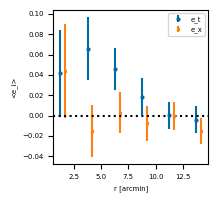

In [43]:
r_max = np.max(r)
print(r_max)

bins = np.linspace(0, r_max, 7)
mid = 0.5 * (bins[1:] + bins[:-1])

e_t_mean, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins)
e_x_mean, _, _ = binned_statistic(r[sel_bg], e_x[sel_bg], bins=bins)

e_t_std, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins,
                                 statistic='std')
e_x_std, _, _ = binned_statistic(r[sel_bg], e_x[sel_bg], bins=bins,
                                 statistic='std')

count, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins,
                               statistic='count')

e_t_err = e_t_std / count ** 0.5
e_x_err = e_x_std / count ** 0.5

plt.figure()
plt.errorbar(mid, e_t_mean, e_t_err, fmt='o', label='e_t')
plt.errorbar(mid+r_max*0.03, e_x_mean, e_x_err, fmt='x', label='e_x')
plt.axhline(0, c='k', ls=':')
plt.xlabel('r [arcmin]')
plt.ylabel('<e_i>')

_ = plt.legend()

> Figure 7: Mean shape profile with error bars estimated by statistical uncertainty.

As mentioned earlier, there are other sources of error in addition to shape noise. For example, the background large-scale structure can introduce correlated noise between radial bins. To fully catch all kinds of error, consider using resampling to estimate the intrinsic scatter of the measurement. 


The result will be very similar to the previous one, because other types of error are much smaller than the shape noise.

Note: It is encouraged that researchers join the LSST Dark Energy Science Collaboration (DESC) to carry out cosmological studies using the Rubin data.